In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp, wilcoxon, ttest_ind, ranksums, sem
%matplotlib inline

In [2]:
LABEL_SIZE = 14; TITLE_SIZE = 16; LEGEND_SIZE = 12

def finalize(ax): 
    ax.tick_params(direction='out')
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.label.set_size(LABEL_SIZE)
    ax.xaxis.label.set_size(LABEL_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)

## Difference in recall between reading passage one or three times

In [3]:
read_once = pd.read_csv('data/pilot_1x40_oct_14_control/info_cleaned.csv')
read_thrice = pd.read_csv('data/pilot_3x40_oct_14_control/info_cleaned.csv')

In [4]:
read_once['number_of_words'] = read_once.response.str.strip().apply(len)
read_thrice['number_of_words'] = read_thrice.response.str.strip().apply(len)

In [5]:
read_once['number_of_uniq_words'] = read_once.response.str.split(' ').apply(set).apply(len)
read_thrice['number_of_uniq_words'] = read_thrice.response.str.split(' ').apply(set).apply(len)

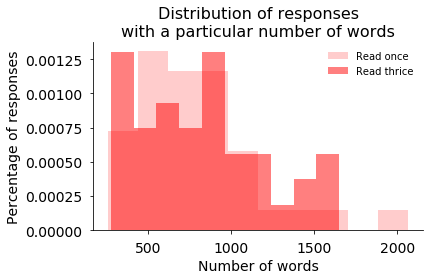

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

read_once['number_of_words'].hist(label='Read once', color='r', alpha=0.2, grid=False, density=True, ax=ax)
read_thrice['number_of_words'].hist(label='Read thrice', color='r', alpha=0.5, grid=False, density=True, ax=ax)

plt.ylabel('Percentage of responses', size=LABEL_SIZE)
plt.xlabel('Number of words', size=LABEL_SIZE)
plt.title('Distribution of responses\nwith a particular number of words', size=TITLE_SIZE)

plt.legend(frameon=False)
finalize(ax)
plt.tight_layout()
plt.savefig('diffs_reading_times.pdf', dpi=1000)

In [7]:
read_once['number_of_words'].describe()

count      38.000000
mean      788.447368
std       365.871244
min       260.000000
25%       529.500000
50%       757.500000
75%       919.250000
max      2065.000000
Name: number_of_words, dtype: float64

In [8]:
read_thrice['number_of_words'].describe()

count      39.000000
mean      829.589744
std       393.846799
min       276.000000
25%       523.000000
50%       819.000000
75%      1032.500000
max      1652.000000
Name: number_of_words, dtype: float64

In [9]:
ks_2samp(read_once['number_of_words'], read_thrice['number_of_words'])

Ks_2sampResult(statistic=0.14844804318488525, pvalue=0.7559154857910084)

In [10]:
ttest_ind(read_once['number_of_words'], read_thrice['number_of_words'])

Ttest_indResult(statistic=-0.47461184118449934, pvalue=0.6364427272337461)

In [11]:
ranksums(read_once['number_of_words'], read_thrice['number_of_words'])

RanksumsResult(statistic=-0.4584919697532844, pvalue=0.6465990304445279)

## Chain versus network analyzed by number of words

In [12]:
chain = pd.read_csv('data/pilot1x10_sept_27/info_cleaned.csv')
network = pd.read_csv('data/pilot3x5x5_sept_30/info_cleaned.csv')

In [13]:
chain['number_of_words'] = chain.response.str.strip().apply(len).astype(float)
network['number_of_words'] = network.response.str.strip().apply(len).astype(float)

In [14]:
chain['number_of_uniq_words'] = chain.response.str.split(' ').apply(set).apply(len)
network['number_of_uniq_words'] = network.response.str.split(' ').apply(set).apply(len)

In [15]:
grouped_chain = chain.sort_values('generation').groupby(['replication'])
chain_response_lengths = list(grouped_chain['number_of_words'].apply(list))

In [16]:
grouped_network = network.groupby(['replication', 'generation'])
network_response_lengths = []; replication_counter = 0; replication_lengths = []
for i, row in grouped_network:
    if i[0] > replication_counter:
        network_response_lengths.append(replication_lengths)
        replication_lengths = []; replication_counter += 1
    
    replication_lengths.append(list(row['number_of_words']))
network_response_lengths.append(replication_lengths)

In [17]:
flattened_network_response_length = [None]*5
for i in range(0, 5):
    for single_network in network_response_lengths:
        if flattened_network_response_length[i] is None:
            flattened_network_response_length[i] = []
        flattened_network_response_length[i].extend(single_network[i])

In [18]:
network_df = pd.DataFrame(flattened_network_response_length)
chain_df = pd.DataFrame(chain_response_lengths)

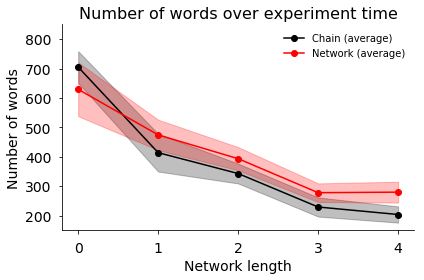

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

## Plot the chain results
# for single_chain in chain_response_lengths:
#     plt.scatter(range(0, len(single_chain)), single_chain, color='black', alpha=0.15)

mean_length = np.array(chain_df.apply(np.nanmean, axis=0))
sem_length = np.array(chain_df.apply(np.nanstd, axis=0))/np.sqrt(chain_df.shape[0]*chain_df.shape[1])

plt.plot(range(0, 5), mean_length, color='black', alpha=1.0, marker='o', label='Chain (average)')
plt.fill_between(range(0, 5), mean_length-2*sem_length, mean_length+2*sem_length, color='black', alpha=0.25)

## Plot the network results
# for single_network in network_response_lengths:
#     for i in range(0, len(single_network)):
#         plt.scatter([i]*len(single_network[i]), single_network[i], color='red', alpha=0.15)

mean_length = network_df.apply(np.nanmean, axis=1)
sem_length = network_df.apply(np.nanstd, axis=1)/np.sqrt(network_df.shape[0]*network_df.shape[1])

plt.plot(range(0, 5), mean_length, color='red', alpha=1.0, marker='o', label='Network (average)')
plt.fill_between(range(0, 5), mean_length-2*sem_length, mean_length+2*sem_length, color='red', alpha=0.25)

## Finish up with styling
plt.ylabel('Number of words', size=LABEL_SIZE)
plt.xlabel('Network length', size=LABEL_SIZE)
plt.title('Number of words over experiment time', size=TITLE_SIZE)
plt.ylim(150, 850)
plt.legend(frameon=False)

finalize(ax)
plt.tight_layout()
plt.savefig('network_vs_chain.pdf', dpi=1000)

## Automatic SVO Parsing

In [20]:
from svo_parsing.subject_extraction import clean_document, extract_subject, tag_sentences, get_svo

In [21]:
all_chain_responses = list(grouped_chain['response'].apply(list))

In [34]:
chain_propositions = []
for rep, single_chain_responses in enumerate(all_chain_responses): 
    replication_propositions = []
    for i, response in enumerate(single_chain_responses):
        cleaned_response = clean_document(response)
        subjects = extract_subject(cleaned_response)
        
        propositions = []
        for subject in subjects:
            tagged_sents = tag_sentences(subject, cleaned_response)
            for sentence in tagged_sents:
                svo = get_svo(sentence, subject)
                if svo != {}:
                    propositions.append('-'.join([svo['subject'], svo['action'], svo['object']]))
        
        replication_propositions.append(len(propositions))
    chain_propositions.append(replication_propositions)

In [35]:
all_network_responses = []; replication_counter = 0; single_network_responses = []
for i, row in grouped_network:
    if i[0] > replication_counter:
        all_network_responses.append(single_network_responses)
        single_network_responses = []; replication_counter += 1
    
    single_network_responses.append(list(row['response']))
all_network_responses.append(single_network_responses)

In [36]:
network_propositions = []
for rep, single_network_responses in enumerate(all_network_responses): 
    level_propositions = []
    for level in single_network_responses:
        replication_propositions = []
        for i, response in enumerate(level):
            cleaned_response = clean_document(response)
            subjects = extract_subject(cleaned_response)

            propositions = []
            for subject in subjects:
                tagged_sents = tag_sentences(subject, cleaned_response)
                for sentence in tagged_sents:
                    svo = get_svo(sentence, subject)
                    if svo != {}:
                        propositions.append('-'.join([svo['subject'], svo['action'], svo['object']]))

            replication_propositions.append(len(propositions))
        level_propositions.append(replication_propositions)
    network_propositions.append(level_propositions)

In [37]:
flattened_network_propositions = [None]*5
for i in range(0, 5):
    for single_network in network_propositions:
        if flattened_network_propositions[i] is None:
            flattened_network_propositions[i] = []
        flattened_network_propositions[i].extend(single_network[i])

In [38]:
network_df = pd.DataFrame(flattened_network_propositions)
chain_df = pd.DataFrame(chain_propositions)

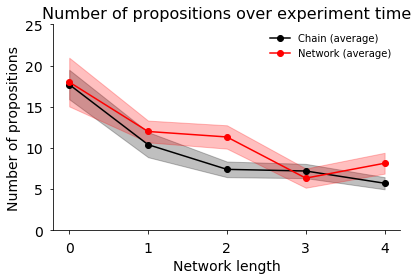

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

mean_length = np.array(chain_df.apply(np.nanmean, axis=0))
sem_length = np.array(chain_df.apply(np.nanstd, axis=0))/np.sqrt(chain_df.shape[0]*chain_df.shape[1])

plt.plot(range(0, 5), mean_length, color='black', alpha=1.0, marker='o', label='Chain (average)')
plt.fill_between(range(0, 5), mean_length-2*sem_length, mean_length+2*sem_length, color='black', alpha=0.25)

mean_length = network_df.apply(np.nanmean, axis=1)
sem_length = network_df.apply(np.nanstd, axis=1)/np.sqrt(network_df.shape[0]*network_df.shape[1])

plt.plot(range(0, 5), mean_length, color='red', alpha=1.0, marker='o', label='Network (average)')
plt.fill_between(range(0, 5), mean_length-2*sem_length, mean_length+2*sem_length, color='red', alpha=0.25)

## Finish up with styling
plt.ylabel('Number of propositions', size=LABEL_SIZE)
plt.xlabel('Network length', size=LABEL_SIZE)
plt.title('Number of propositions over experiment time', size=TITLE_SIZE)
plt.ylim(0, 25)
plt.legend(frameon=False)

finalize(ax)
plt.tight_layout()
plt.savefig('network_vs_chain_svo.pdf', dpi=1000)